In [ ]:
import json
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import librosa
from google.colab import drive
import os
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2
from sklearn.utils import shuffle

# Mount Google Drive for access
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:


# Load X_train from JSON
with open('/content/drive/MyDrive/My-207/X_train_centroid.json', 'r') as file:
    X_train_list = json.load(file)

# Load y_train from JSON
with open('/content/drive/MyDrive/My-207/y_train_centroid.json', 'r') as file:
    y_train_list = json.load(file)

# Load X_val from JSON
with open('/content/drive/MyDrive/My-207/X_val_centroid.json', 'r') as file:
    X_val_list = json.load(file)

# Load y_val from JSON
with open('/content/drive/MyDrive/My-207/y_val_centroid.json', 'r') as file:
    y_val_list = json.load(file)



In [ ]:
import numpy as np

X_train = np.array(X_train_list)
y_train = np.array(y_train_list)
X_val = np.array(X_val_list)
y_val = np.array(y_val_list)

In [ ]:
# # Reshape the arrays to have the correct input shape for CNN model
# input_shape = (X_train.shape[1], X_train.shape[2], 1)
# X_train = X_train[..., np.newaxis]
# X_val = X_val[..., np.newaxis]


In [ ]:
# Data normalization
from sklearn.preprocessing import StandardScaler

# Flatten X_train and X_val into 2-dimensional arrays
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_val_flat = X_val.reshape(X_val.shape[0], -1)

# Initialize the scaler and fit it on the training data
scaler = StandardScaler()
scaler.fit(X_train_flat)

# Transform both training and validation data using the scaler parameters
X_train_normalized = scaler.transform(X_train_flat)
X_val_normalized = scaler.transform(X_val_flat)

# Reshape back to 3-dimensional arrays
X_train_normalized = X_train_normalized.reshape(X_train.shape)
X_val_normalized = X_val_normalized.reshape(X_val.shape)

# Convert string labels to numerical labels
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

# Save the label encoder for later use (optional)
import joblib
label_encoder_path = "label_encoder.pkl"
joblib.dump(label_encoder, label_encoder_path)

['label_encoder.pkl']

In [ ]:
X_train, train_y = shuffle(X_train, y_train, random_state=1234)
X_val, val_y = shuffle(X_val, y_val, random_state=1234)

In [ ]:

# Build CNN model topology for spectral centroid data
model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(32, kernel_size=3, activation='relu', input_shape=(X_train_normalized.shape[1], 1), kernel_regularizer=l2(0.001)),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Conv1D(64, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
tf.keras.layers.Dropout(0.5),  # Dropout layer with 50% dropout rate
    tf.keras.layers.Dense(len(label_encoder.classes_), activation='softmax')
])

# model = tf.keras.Sequential([
#     tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(X_train_normalized.shape[1], 1),
#                            kernel_regularizer=l2(0.001)),  # L2 regularization
#     tf.keras.layers.MaxPooling2D(pool_size=(2)),
#     tf.keras.layers.Conv2D(64, kernel_size=(3), activation='relu', kernel_regularizer=l2(0.001)),  # L2 regularization
#     tf.keras.layers.MaxPooling2D(pool_size=(2)),
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=l2(0.001)),  # L2 regularization
#     tf.keras.layers.Dropout(0.5),  # Dropout layer with 50% dropout rate
#     tf.keras.layers.Dense(len(label_encoder.classes_), activation='softmax')
# ])

In [ ]:
# Compile model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Summary of the model
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_10 (Conv1D)          (None, 249, 32)           128       
                                                                 
 max_pooling1d_10 (MaxPoolin  (None, 124, 32)          0         
 g1D)                                                            
                                                                 
 conv1d_11 (Conv1D)          (None, 122, 64)           6208      
                                                                 
 max_pooling1d_11 (MaxPoolin  (None, 61, 64)           0         
 g1D)                                                            
                                                                 
 flatten_6 (Flatten)         (None, 3904)              0         
                                                                 
 dense_12 (Dense)            (None, 128)              

In [ ]:
# Train the model with early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

history = model.fit(X_train_normalized, y_train_encoded, validation_data=(X_val_normalized, y_val_encoded), batch_size=32, epochs=100,
                    callbacks=[early_stopping])


Epoch 1/100
143/143 [==============================] - 3s 16ms/step - loss: 1.1192 - accuracy: 0.5148 - val_loss: 1.0199 - val_accuracy: 0.5098
Epoch 2/100
143/143 [==============================] - 2s 14ms/step - loss: 0.9114 - accuracy: 0.6371 - val_loss: 0.9314 - val_accuracy: 0.5860
Epoch 3/100
143/143 [==============================] - 2s 14ms/step - loss: 0.8260 - accuracy: 0.6918 - val_loss: 0.8947 - val_accuracy: 0.6090
Epoch 4/100
143/143 [==============================] - 2s 17ms/step - loss: 0.7891 - accuracy: 0.7052 - val_loss: 0.8731 - val_accuracy: 0.6336
Epoch 5/100
143/143 [==============================] - 3s 19ms/step - loss: 0.7500 - accuracy: 0.7286 - val_loss: 0.9066 - val_accuracy: 0.6280
Epoch 6/100
143/143 [==============================] - 2s 14ms/step - loss: 0.7313 - accuracy: 0.7416 - val_loss: 0.8639 - val_accuracy: 0.6482
Epoch 7/100
143/143 [==============================] - 2s 14ms/step - loss: 0.7050 - accuracy: 0.7572 - val_loss: 0.8639 - val_accuracy:

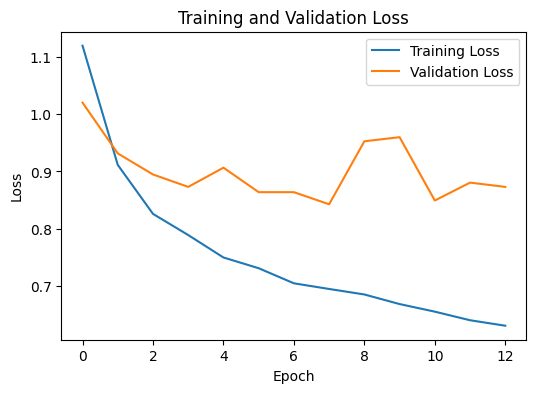

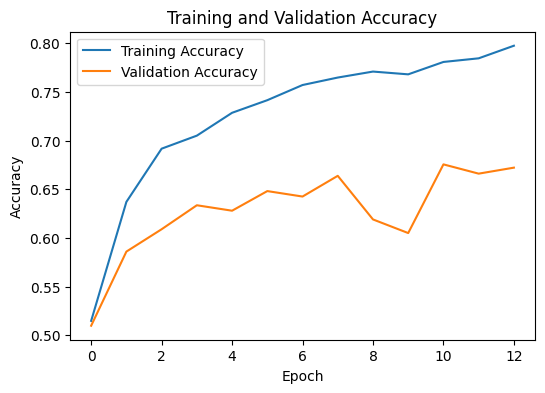

In [ ]:




# Plot the training and validation loss
plt.figure(figsize=(6, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plot the training and validation accuracy
plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

